## Case Study - Churn Prediction

In [38]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
sys.path.append("../")
from src.clean_churn_data import clean_churn_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve
from sklearn.pipeline import make_pipeline
from src.helper import accuracy_scores, plot_roc_curve, train_test_score
from src.confusion_df import confusion_df, render_mpl_table
from sklearn.ensemble import GradientBoostingClassifier

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get data ready for model

In [5]:
# Clean data using helper function
data = pd.read_csv('../data/churn_train.csv')
data_clean = clean_churn_data(data)

# Create a copy of data for making models
df_copy = data_clean.copy()
y = df_copy.pop('churn?').values
X = df_copy.values

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train.shape, X_test.shape

((29760, 12), (9921, 12))

## Gradient Boosting Classifier

(<Figure size 576x135 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa08af0b450>)

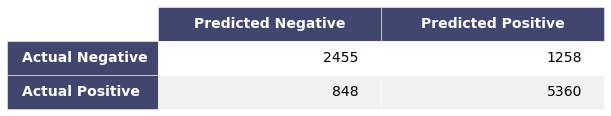

In [39]:
# Make model and get accuracy scores/confusion matrix
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
accuracy_scores(y_test, y_hat)
df = confusion_df(y_test, y_hat)
render_mpl_table(df)

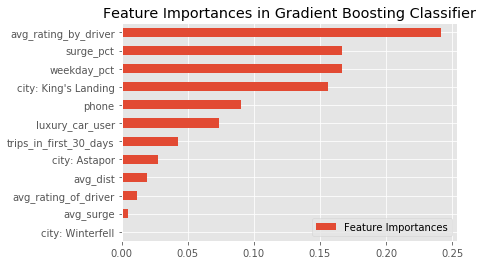

In [10]:
# Feature Importances
importances = pd.DataFrame({'Feature Importances': model.feature_importances_}, 
                       index=df_copy.columns)

importances = importances.sort_values(by='Feature Importances')
importances.plot(kind='barh')
plt.title("Feature Importances in Gradient Boosting Classifier")
plt.savefig("../img/feature_import_gbc.png", bbox_inches='tight', dpi=350)

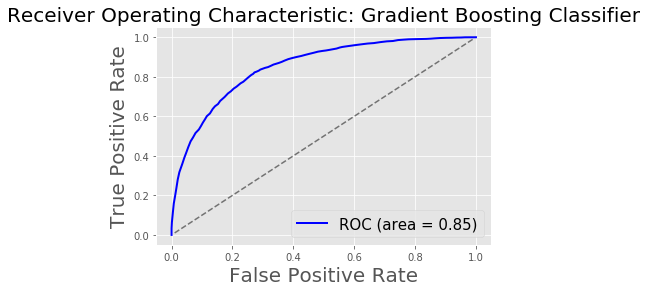

In [11]:
# Plot receiver operating characteristics (ROC) 
model.classes_ # This tells us that class [0] = 0 and class[1] = 1
proba_true = model.predict_proba(X_test)[:,1]
fig, ax = plt.subplots()
plot_roc_curve(proba_true, y_test, ax, 'Gradient Boosting Classifier')
plt.savefig('../img/roc_gbc.png', dpi=250)

In [12]:
# Save labels for laters
np.savetxt('../data/gbc_yproba.txt', proba_true)
np.savetxt('../data/gbc_ytrue.txt', y_test)

## Tuning Parameters

In [27]:
# First look at n_estimators
n = 3000
model = GradientBoostingClassifier(n_estimators=n)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

train_score, test_score = train_test_score(3000, model, X_train, X_test, y_train, y_test)

826


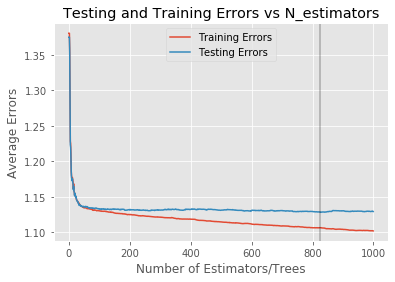

In [32]:
fig, ax = plt.subplots()
ax.plot(train_score[:1000], label="Training Errors")
ax.plot(test_score[:1000], label="Testing Errors")
ax.set_xlabel("Number of Estimators/Trees")
ax.set_ylabel("Average Errors")
ax.legend()
ax.set_title("Testing and Training Errors vs N_estimators")
ax.axvline(x=826, color='black', linewidth=0.4)
plt.savefig("../img/test_train_errors_gbc.png", dpi=250)

opt_estimators = np.argmin(test_score)
print(opt_estimators)

It looks like the minimum occurs close to 800 trees, but the change between ~130 trees and 1000 trees is minimal. 

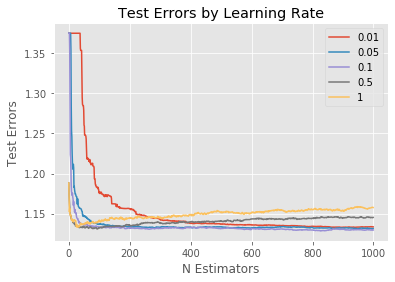

In [37]:
# Now look at learning rate and plot ROC curve for each
lr = [0.01, 0.05, 0.1, 0.5, 1]
fig, ax = plt.subplots()

# Loop through learning rates
for l in lr:
    n_estimators = 1000
    m = GradientBoostingClassifier(learning_rate=l, n_estimators=n_estimators)
    m.fit(X_train, y_train)
    
    train_score, test_score = train_test_score(n_estimators, m, X_train, X_test, y_train, y_test)
    
    ax.plot(test_score, label=l)
    ax.set_title("Test Errors by Learning Rate")
    ax.set_xlabel("N Estimators")
    ax.set_ylabel("Test Errors")    
    ax.legend()
    plt.savefig('../img/lr_errors_gbc.png', dpi=250)

## Now let's run our optimized model on the actual test data! 

In [33]:
# Run on true test data
data_test = pd.read_csv('../data/churn_test.csv')
dt_clean = clean_churn_data(data_test)
yt = dt_clean.pop('churn?').values
Xt = dt_clean.values
yt.shape, Xt.shape

((9923,), (9923, 12))

(<Figure size 576x135 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa08b013d10>)

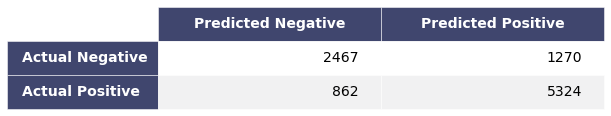

In [41]:
# Create the optimized model
model_opt = GradientBoostingClassifier(n_estimators=opt_estimators)
model_opt.fit(X_train, y_train)
y_pred = model_opt.predict(Xt)

# Get some statistics
a, r, p, mse = accuracy_scores(yt, y_pred)
df = confusion_df(yt, y_pred)
render_mpl_table(df)

In [42]:
a, r, p

(0.785, 0.861, 0.807)

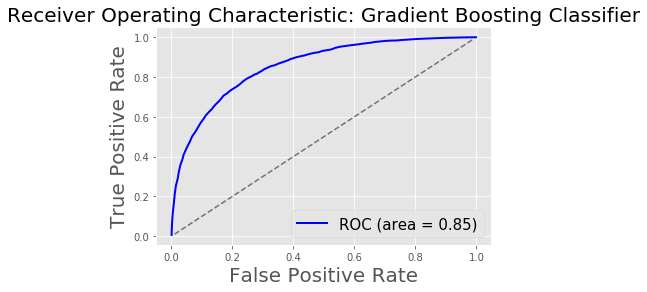

In [36]:
# Plot the roc curve
fig, ax = plt.subplots()
plot_roc_curve(model_opt.predict_proba(Xt)[:,1], yt, ax, "Gradient Boosting Classifier" )